In [1]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sklearn
import sys

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Python ≥3.5 is required
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('fivethirtyeight')

# to make this notebook's output stable across runs
np.random.seed(42)

IMAGE_PATH = os.path.join('./images')


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Loading the data

In [3]:
DATA_PATH = '../MLP2/input/'

# loading the audio file data
audio_df = pd.read_csv(DATA_PATH+'audio_data.csv') # we probably wont use this until we know how to neural network
audio_means_df = pd.read_csv(
    DATA_PATH + 'audio_means.csv')

# loading the .csv file data
song_dropped_df = pd.read_csv(
    DATA_PATH + 'dropped.csv')
song_filled_df = pd.read_csv(
    DATA_PATH + 'mean_filled.csv')

In [4]:
song_dropped_df = song_dropped_df.drop(columns=['artist_name','track_name','instance_id'])
song_filled_df = song_filled_df.drop(columns=['artist_name','track_name'])

In [5]:
keys = dict()
i = 0
for key in sorted(song_filled_df['key'].unique()):
    keys[key] = i
    i+=1

modes = dict({song_filled_df['mode'].unique()[0]:0, song_filled_df['mode'].unique()[1]:1})

In [6]:
song_dropped_df['key'] = song_dropped_df['key'].apply(lambda x: keys[x])
song_dropped_df['mode'] = song_dropped_df['mode'].apply(lambda x: modes[x])

song_filled_df['key'] = song_filled_df['key'].apply(lambda x: keys[x])
song_filled_df['mode'] = song_filled_df['mode'].apply(lambda x: modes[x])

In [7]:
audio_genres = audio_df['genre'].unique()
dropped_genres = song_dropped_df['music_genre'].unique()
filled_genres = song_filled_df['music_genre'].unique()

audio_features = audio_means_df.columns.drop('genre')
dropped_features = song_dropped_df.columns.drop('music_genre')
filled_features = song_filled_df.columns.drop('music_genre')

# Modeling

## Splitting the data

Separating data from labels

In [8]:
# audio data with means
X_audio = audio_means_df.loc[:, audio_means_df.columns != 'genre']
y_audio = audio_means_df['genre']

# song data with dropped null values
X_dropped = song_dropped_df.loc[:, song_dropped_df.columns != 'music_genre']
y_dropped = song_dropped_df['music_genre']

# song data with mean filled null values
X_filled = song_filled_df.loc[:, song_filled_df.columns != 'music_genre']
y_filled = song_filled_df['music_genre']

In [9]:
print(len(X_audio))
print(len(X_dropped))
print(len(X_filled))

1000
40560
50000


creating the splits

In [10]:
from sklearn.model_selection import train_test_split

# audio data with means
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(
    X_audio, y_audio, test_size=0.20)

X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test = train_test_split(
    X_dropped, y_dropped, test_size=0.30)

X_filled_train, X_filled_test, y_filled_train, y_filled_test = train_test_split(
    X_filled, y_filled, test_size=0.30)


## Training

In [11]:
# loading libraries
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error


In [12]:
# def test_splits(pipe, params, X, y, df, model, test_size=[.15,0.2, 0.25, 0.3]):
#     for size in test_size:
#         X_train, X_test, y_train, y_test = train_test_split(X_audio, y_audio, test_size=size)

def run_GSCV(pipe, params, X, y, label):
    clf_GSCV = GridSearchCV(pipe, params)
    clf_GSCV.fit(X, y)
    df = pd.DataFrame(clf_GSCV.cv_results_)
    df['label'] = label
    return df

### Decision Tree

In [13]:
tree_results_df = pd.DataFrame()
sc = StandardScaler()
dtreeClf = tree.DecisionTreeClassifier()

pipe = Pipeline(steps=[('sc', sc),
                       ('dtreeClf', dtreeClf)])

n_components = list(range(1, X_audio.shape[1] + 1, 1))

criterion = ['gini', 'entropy']
max_depth = [4, 6, 8, 10]

parameters = dict(
                  dtreeClf__criterion=criterion,
                  dtreeClf__max_depth=max_depth)
                  
tree_results_df = tree_results_df.append(
    run_GSCV(pipe, parameters, X_audio, y_audio, 'Audio')).append(
    run_GSCV(pipe, parameters, X_dropped, y_dropped, 'Dropped')).append(
    run_GSCV(pipe, parameters, X_filled, y_filled, 'Filled'))

In [14]:
best_audio_tree = tree_results_df[(tree_results_df.rank_test_score == 1) &
                (tree_results_df.label == 'Audio')]

best_dropped_tree = tree_results_df[(tree_results_df.rank_test_score == 1) &
                                  (tree_results_df.label == 'Dropped')]

best_filled_tree = tree_results_df[(tree_results_df.rank_test_score == 1) &
                                    (tree_results_df.label == 'Filled')]

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix

clf_audio = DecisionTreeClassifier(
    criterion=best_audio_tree['param_dtreeClf__criterion'].values[0],
    max_depth=best_audio_tree['param_dtreeClf__max_depth'].values[0]).fit(X_audio_train, y_audio_train)

clf_dropped = DecisionTreeClassifier(
    criterion=best_dropped_tree['param_dtreeClf__criterion'].values[0],
    max_depth=best_dropped_tree['param_dtreeClf__max_depth'].values[0]).fit(X_dropped_train, y_dropped_train)

clf_filled = DecisionTreeClassifier(
    criterion=best_filled_tree['param_dtreeClf__criterion'].values[0],
    max_depth=best_filled_tree['param_dtreeClf__max_depth'].values[0]).fit(X_filled_train, y_filled_train)

y_pred_audio = clf_audio.predict(X_audio_test)
y_pred_dropped = clf_dropped.predict(X_dropped_test)
y_pred_filled = clf_filled.predict(X_filled_test)

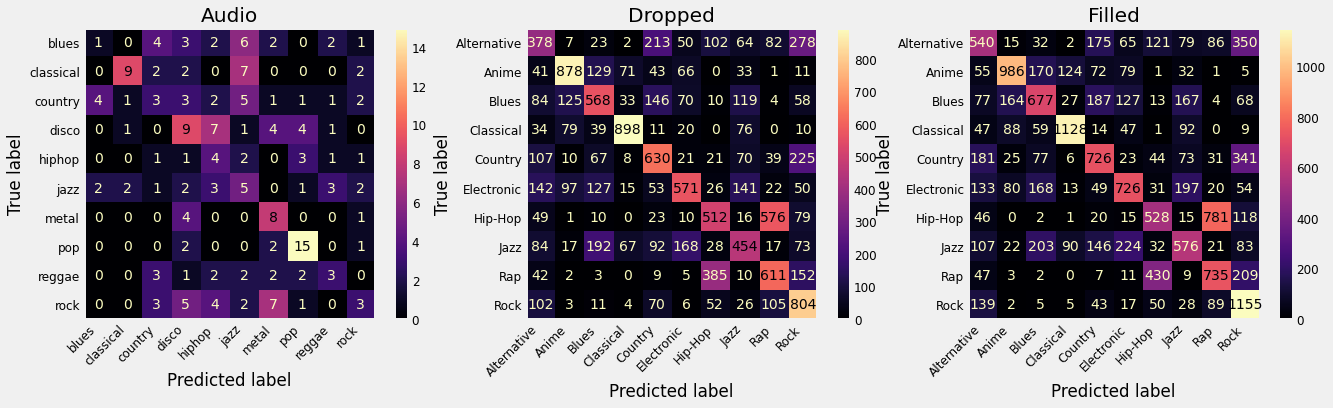

In [16]:
fig, axs = plt.subplots(1,3, figsize = (20,5))

plot_confusion_matrix(clf_audio, X_audio_test, y_audio_test, ax=axs[0], cmap = 'magma')
plot_confusion_matrix(clf_dropped, X_dropped_test,
                      y_dropped_test, ax=axs[1], cmap='magma')
plot_confusion_matrix(clf_filled, X_filled_test,
                      y_filled_test, ax=axs[2], cmap='magma')

axs[0].set(title='Audio')
axs[1].set(title='Dropped')
axs[2].set(title='Filled')

for i in range(3):
    axs[i].set_xticklabels(
        axs[i].get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    axs[i].grid(False)

plt.show()

In [17]:
result_metrics_audio = classification_report(y_audio_test, y_pred_audio)
result_metrics_dropped = classification_report(y_dropped_test, y_pred_dropped)
result_metrics_filled = classification_report(y_filled_test, y_pred_filled)

print('\n\nAudio\n', result_metrics_audio)
print('\n\nDropped\n', result_metrics_dropped)
print('\n\nFilled\n',result_metrics_filled)



Audio
               precision    recall  f1-score   support

       blues       0.14      0.05      0.07        21
   classical       0.69      0.41      0.51        22
     country       0.18      0.13      0.15        23
       disco       0.28      0.33      0.31        27
      hiphop       0.17      0.31      0.22        13
        jazz       0.17      0.24      0.20        21
       metal       0.31      0.62      0.41        13
         pop       0.56      0.75      0.64        20
      reggae       0.27      0.20      0.23        15
        rock       0.23      0.12      0.16        25

    accuracy                           0.30       200
   macro avg       0.30      0.32      0.29       200
weighted avg       0.30      0.30      0.28       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.36      0.32      0.33      1199
       Anime       0.72      0.69      0.70      1273
       Blues       0.49      0.47      0.48      1217
   C

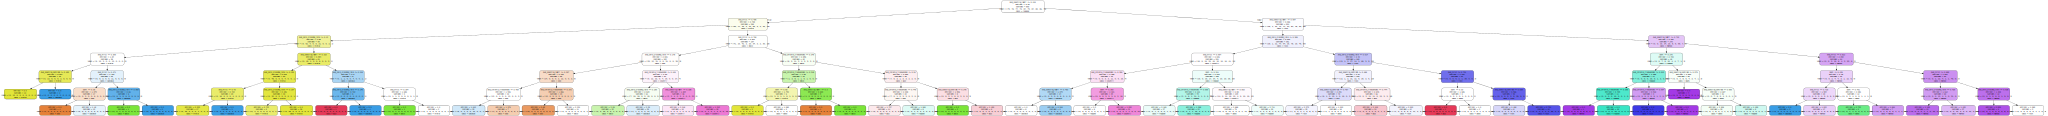

In [18]:
from graphviz import Source
from sklearn.tree import export_graphviz
import pydotplus

dot_data = export_graphviz(
    clf_audio,
    rounded=True,
    filled=True,
    feature_names=audio_features,
    class_names=audio_genres
)

out_file = os.path.join(IMAGE_PATH, "audio_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"65,50!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())


In [19]:
dot_data = export_graphviz(
    clf_dropped,
    rounded=True,
    filled=True,
    feature_names=dropped_features,
    class_names=dropped_features
)

out_file = os.path.join(IMAGE_PATH, "dropped_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"100,100!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())


In [20]:
dot_data = export_graphviz(
    clf_filled,
    rounded=True,
    filled=True,
    feature_names=filled_features,
    class_names=filled_features
)
out_file = os.path.join(IMAGE_PATH, "filled_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"100,100!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())

### kNN Classifier

In [21]:
from sklearn.neighbors import KNeighborsClassifier
knn_audio = KNeighborsClassifier(n_neighbors=30).fit(X_audio_train, y_audio_train)
knn_dropped = KNeighborsClassifier(n_neighbors=30).fit(X_dropped_train, y_dropped_train)
knn_filled = KNeighborsClassifier(n_neighbors=30).fit(X_filled_train, y_filled_train)

y_pred_knn_audio = knn_audio.predict(X_audio_test)
y_pred_knn_dropped = knn_dropped.predict(X_dropped_test)
y_pred_knn_filled = knn_filled.predict(X_filled_test)

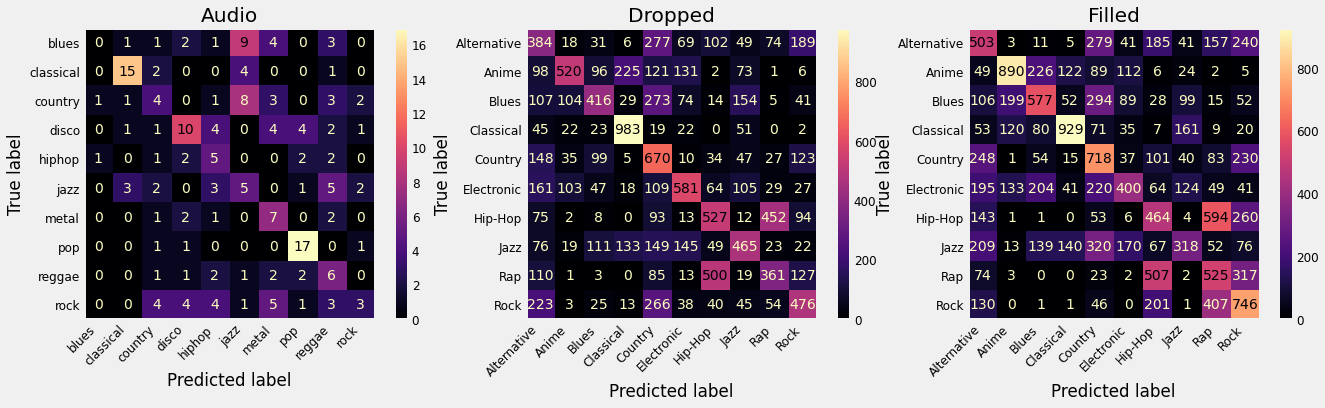

In [22]:
fig, axs = plt.subplots(1,3, figsize = (20,5))

plot_confusion_matrix(knn_audio, X_audio_test, y_audio_test, ax=axs[0], cmap = 'magma')
plot_confusion_matrix(knn_dropped, X_dropped_test,
                      y_dropped_test, ax=axs[1], cmap='magma')
plot_confusion_matrix(knn_filled, X_filled_test,
                      y_filled_test, ax=axs[2], cmap='magma')

axs[0].set(title='Audio')
axs[1].set(title='Dropped')
axs[2].set(title='Filled')

for i in range(3):
    axs[i].set_xticklabels(
        axs[i].get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    axs[i].grid(False)

plt.show()

In [23]:
knn_result_metrics_audio = classification_report(y_audio_test, y_pred_knn_audio)
knn_result_metrics_dropped = classification_report(y_dropped_test, y_pred_knn_dropped)
knn_result_metrics_filled = classification_report(y_filled_test, y_pred_knn_filled)

print('\n\nAudio\n', knn_result_metrics_audio)
print('\n\nDropped\n', knn_result_metrics_dropped)
print('\n\nFilled\n', knn_result_metrics_filled)



Audio
               precision    recall  f1-score   support

       blues       0.00      0.00      0.00        21
   classical       0.71      0.68      0.70        22
     country       0.22      0.17      0.20        23
       disco       0.45      0.37      0.41        27
      hiphop       0.24      0.38      0.29        13
        jazz       0.18      0.24      0.20        21
       metal       0.28      0.54      0.37        13
         pop       0.63      0.85      0.72        20
      reggae       0.22      0.40      0.29        15
        rock       0.33      0.12      0.18        25

    accuracy                           0.36       200
   macro avg       0.33      0.38      0.34       200
weighted avg       0.34      0.36      0.33       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.27      0.32      0.29      1199
       Anime       0.63      0.41      0.50      1273
       Blues       0.48      0.34      0.40      1217
   C

In [24]:
# kf = KFold(n_splits=5, random_state=None, shuffle=True) # Define the split - into 5 folds 
# kf.get_n_splits(X_audio) # returns the number of splitting iterations in the cross-validator
# print(kf)

### Logistic Regression

### Random Forest